#Mini Project 2

In [23]:
from google.colab import drive
import sys
import warnings
import os
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
import pandas as pd
import time
import numpy as np 
import nltk
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.exceptions import ConvergenceWarning

drive.mount('/content/drive')
nltk.download('stopwords')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Classes

###Multinomial Naive Bayes

In [12]:
class MultinomialNaiveBayes():
  def __init__(self, alpha=1,hyperparameter_name=None,solver=None ):
    '''
    param alpha: constant for Laplace smoothing
    param hyperparameter_name: None. Allows for the class to be instantiated in the model tester class. 
    param hyperparameter_name: None. Allows for the class to be instantiated in the model tester class. 
    '''
    self.alpha= alpha
    return

  def fit(self,x,y):
     '''
     param x: train set features
     param y: train set labels
     '''
     N, D = x.shape 
     C = np.max(y) + 1 #find the number of classes 
     alpha=self.alpha #get the hyper parameter alpha 
     #theta represents the conditional probiliy of each class given each feature  
     theta= np.zeros((C,D))
     Nc = np.zeros(C) # number of instances in class c 
     # for each class get the conditional probility of the class given feature
     for c in range(C):
            x_c = x[y == c]                           #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of that class 
            theta[c,:] = np.sum(x_c,0)                  #sum of features of class c (find the numerator)
    #theta is set to its proper value as the conditional probility of the class given the feature 
     theta[:]=(theta[:]+alpha)/(np.sum(x,0)+D+1) #divide by total instances of the words while also doing laplace smooting 
     self.theta= theta
     self.pi= (Nc+1)/(N+C) #smoothing for the prior 
     return self

  def predict(self, xt):
      '''
      param xt: test set features
      returns: prediction for labels on test set
      '''
      Nt, D = xt.shape
      log_prior = np.log(self.pi)[:, None] # calculate the log of the prior
      # find the log sum of the input multiplied by theta elementwise for each class and then add the log of the prior of that class
      #this gives us values proportional to the relative probabilities of each class
      def find_prob_of_classes(sparse): # calculate the probability of each calss given the inputs xt 
        sample_likelihood = [] 
        for c in range(self.theta.shape[0]):
          likelihood = sparse*np.log(self.theta[c])
          likelihood = np.sum(likelihood) #+log_prior[c][0] ##why do we do this twice ?? we seem to be multiplying by the prior twice what is this period too?
          likelihood = likelihood + log_prior[c][0]
          sample_likelihood.append(likelihood)
        return sample_likelihood
      y_prob = [] 
      for element in xt:
        y_prob.append(find_prob_of_classes(element))
      y_pred = np.argmax(y_prob,1)#return most likely class for each input not probability

      return y_pred



###Cross Validation

In [13]:
class sets():
  '''Container for the dataset being tested'''

  def __init__(self, X_train, Y_train, X_test, Y_test, test_prop = 0.2, L = 5, rel_size = 1.0, max_test_size = 1000):
    '''
    param X_train: training set features
    param Y_train: labels for training set
    param X_test: test set features 
    param Y_test: labels for test set
    param test_prop: size of test set relative to train set (default 0.2: test set is 1/5 the size of the training set)
    param L: number of folds for L fold cross validation
    param rel_size: size of desired training set relative to available data
    param max_test_set_size: max size of test set (to speed up computation)
    '''
    train_set_size = X_train.shape[0] 
    X_train = X_train[:int(train_set_size*rel_size)] #slice desired train set size
    Y_train = Y_train[:int(train_set_size*rel_size)]
    test_set_size = int(train_set_size * test_prop) #get appropriate number of test examples 
    if test_set_size > max_test_size: 
      test_set_size = max_test_size #cap off the size of the test set if necessary

    self.x_train = X_train
    self.y_train = np.array(Y_train)
    self.x_test = X_test[:test_set_size]
    self.y_test = np.array(Y_test[:test_set_size]) #slice test set
    self.L = L

  def cross_validation_split(self):
    '''
    L fold cross validation function which generates subsets of the training set
    yield x_train: subtraining set features
    yield y_train: subtraining set labels
    yield x_val: validation set features
    yield y_val: validation set labels
    '''
    dataset_size = self.y_train.shape[0]
    indices = list(range(dataset_size))
    num_val = dataset_size // self.L #size of validation set
    for l in range(self.L):
      validation_indices = list(range(l * num_val, (l+1)*num_val)) #get indices for the next validation set 
      train_indices = [x for x in indices if x not in validation_indices]  #get indices for the sub train set
      x_train, x_val = self.x_train[train_indices], self.x_train[validation_indices] #slice out
      y_train, y_val = self.y_train[train_indices], self.y_train[validation_indices]
      yield x_train, y_train, x_val, y_val
      

###Tester

In [14]:
class model_tester():
  '''Class used to test the models using cross validation'''

  def __init__(self, model, datasets, hyperparameters, hyperparameter_name = 'regularization', solver = 'saga', val_limit = 500):
    '''
    param model: class variable of the model being tested 
    param hyperparameters: array of hyperparameters being tested
    param hyperparameter_name: string of hyperparameter name for displaying results
    param solver: solver type for logistic regression (set to None for Naive Bayes)
    param val_limit: limit on the number of example used for validation testing (to speed things up)
    '''
    self.model_class = model
    self.datasets = datasets
    self.hyperparameters = hyperparameters
    self.hyperparameter_name = hyperparameter_name
    self.solver = solver
    self.val_limit = val_limit

  def initialize_model(self, h):
    '''Initializing the model with the desired hyperparameter h'''
    return self.model_class(h, self.hyperparameter_name, self.solver)

  def test(self):
    '''Tester used for cross validation
    returns metrics: object containing all the performance metrics'''
    num_class = np.unique(self.datasets.y_train).shape[0] #get the number of classes (used for metrics)
    metrics = model_metrics(self, self.datasets) #initialize our metrics object
    for i,h in enumerate(self.hyperparameters): #iterate over the hyperparameters
      for f, sets in enumerate(self.datasets.cross_validation_split()): #for each hyperparameter, iterate over the validation sets
        (x_train, y_train, x_val, y_val) = sets #get the validation set, and the sub trainset
        x_val, y_val = x_val[:self.val_limit], y_val[:self.val_limit]	#slice out to the desired max size (speed things up)	
        model = self.initialize_model(h)         #initialize the model
        start = time.time()
        y_val_pred = model.fit(x_train, y_train).predict(x_val) #fit training data and predict on validation data
        timing = time.time() - start #get the time it took to train and predict
        print(f'...Training and testing for hyperparameter {i+1} on validation fold {f+1}') 
        metrics.update_metrics(True, i, f, y_val_pred, y_val, timing) #update the metrics
      model = self.initialize_model(h) #initialize the model again for the test set
      start = time.time()
      y_prediction = model.fit(self.datasets.x_train, self.datasets.y_train).predict(self.datasets.x_test) #fit training data and predict on test data     
      timing = time.time() - start
      print(f'...Training and testing for hyperparameter {i+1} on test set')
      metrics.update_metrics(False, i, f, y_prediction, self.datasets.y_test, timing) #update metrics again
    return metrics


###Performance Analysis

In [16]:
class model_metrics(): 
  '''This class is used to hold the performance metrics on all the validation tests and tests on the test set'''
  def __init__(self, tester, datasets):
    '''
    param tester: tester object (used to pass the hyperparameter array and hyperparameter name)
    datasets: sets object containing validation count L
    '''
    L  = datasets.L #Validation count
    self.hyperparameter_name = tester.hyperparameter_name 
    self.hyperparameters = tester.hyperparameters
    hyperparameter_range = tester.hyperparameters.shape[0]
    #initialize the arrays containing the performance metrics
    self.accuracy = [np.zeros((hyperparameter_range, L)), np.zeros((hyperparameter_range))] #accuracy 
    self.recall = [np.zeros((hyperparameter_range, L)), np.zeros((hyperparameter_range))] #recall
    self.precision = [np.zeros((hyperparameter_range, L)), np.zeros((hyperparameter_range))] #precision
    self.f1 = [np.zeros((hyperparameter_range, L)), np.zeros((hyperparameter_range))] #f1
    self.timing = [np.zeros((hyperparameter_range, L)), np.zeros((hyperparameter_range))] #time to train and test
  
  def show_results(self, log = None):
    '''Display plots of performance vs hyperparameter
    param log: if True is passed, scaled of x axis is log scale 
    '''
    plt.suptitle('Peformance Metrics on Validation and Test Sets',fontsize=20, x =0.4)
    m = {'Accuracy': self.accuracy, 'Recall':self.recall, 'Precision': self.precision, 'F1': self.f1, 'Timing':self.timing}
    fig = plt.figure(figsize= (20,12))
    for i,metric in enumerate(m):
      fig.add_subplot(3,2,i+1)
      plt.plot(self.hyperparameters, m[metric][1],  label=(f'{metric} on test set'))
      plt.errorbar(self.hyperparameters, np.mean(m[metric][0], axis=1), np.std(m[metric][0], axis=1), label=(f'{metric} on validation set'))
      plt.legend(), plt.xlabel(self.hyperparameter_name), plt.ylabel(metric)
      if log != None:
        plt.xscale("log")
    fig.tight_layout(rect=[0.03, 0.03, 0.8, 0.97])
    plt.show()
  
  def update_metrics(self,validation, i, f, y_pred, y_test, timing): 
    '''
    Updating the arrays to contain the performance on the latest test
    param validation: boolean (True for validation test, False for test set test)
    param y_pred: array of prediction
    param y_test: array of true labels
    param timing: time for latest train and predict
    '''
    num_class = np.unique(y_test).shape[0] 
    if num_class < 3:
      avg ='binary' 
    else: 
      avg = 'micro' #multiclass precision, recall and f1 requires the parameter micro
    if validation == True: 
      self.accuracy[0][i, f] = self.evaluate_acc(y_pred, y_test.flatten()) #get accuracy and update
      self.precision[0][i, f] = self.evaluate_precision(y_pred, y_test.flatten(), avg)  #get precision and update
      self.recall[0][i, f] = self.evaluate_recall(y_pred, y_test.flatten(), avg)  #get recall and update
      self.f1[0][i, f] = self.evaluate_f1(y_pred, y_test.flatten(), avg)  #get f1 and update
      self.timing[0][i,f] = timing #update timing
    else: 
      self.accuracy[1][i] = self.evaluate_acc(y_pred, y_test.flatten())
      self.precision[1][i] = self.evaluate_precision(y_pred, y_test.flatten(), avg)
      self.recall[1][i] = self.evaluate_recall(y_pred, y_test.flatten(), avg)
      self.f1[1][i] = self.evaluate_f1(y_pred, y_test.flatten(), avg)
      self.timing[1][i] = timing

  def get_best(self):
    '''
    Returns the best hyperparameter on the validation sets using the best average accuracy
    Returns the best average accuracy on validation sets 
    Returns the accuracy of the model: test set accuracy for the hyperparameter at which validation had the best average accuracy
    Returns the best hyperparameter on the test set using ccuracy
    Returns the best average accuracy on test set
    '''
    best_accuracy_val = np.mean(self.accuracy[0], axis=1).max()
    best_hyperparameter_val = self.hyperparameters[np.argmax(np.mean(self.accuracy[0], axis=1))]
    best_accuracy_t = self.accuracy[1].max()
    best_hyperparameter_t = self.hyperparameters[np.argmax(self.accuracy[1])]
    i = np.where(self.hyperparameters == best_hyperparameter_val)[0][0]
    accuracy = self.accuracy[1][i]
    print(f'\nHighest average accuracy on validation set: {best_accuracy_val :.3f} with {self.hyperparameter_name} of {best_hyperparameter_val}')
    print(f'\nAccuracy on test set:  {best_accuracy_val :.3f} with {self.hyperparameter_name} of {best_hyperparameter_val}')
    print(f'\nAccuracy:  {accuracy :.3f}')
    return best_accuracy_val, best_hyperparameter_val, accuracy, best_accuracy_t, best_hyperparameter_t

  def evaluate_acc(self,y_prediction, y_test): #return accuracy using prediction and labels
    return np.sum(y_prediction == y_test) / y_test.shape[0] * 100

  def evaluate_recall(self,y_prediction, y_test, avg): #return recall using prediction and labels
    return recall_score(y_test, y_prediction, average = avg)
    
  def evaluate_precision(self,y_prediction, y_test, avg): #return precision using prediction and labels
    return precision_score(y_test, y_prediction, average = avg)

  def evaluate_f1(self,y_prediction, y_test, avg): #return f1 using prediction and labels
    return f1_score(y_test, y_prediction, average = avg)


###Logistic Regression

In [18]:
class logistic_regression():
  '''
  logistic regression container class
  param hyperparameter_name: 'regularization' or 'max iterations' (hyperparameter being tested)
  param c: hyper parameter to test
  solver: 'saga' or 'lbfgs'  
  '''
  def __init__(self,c, hyperparameter_name, solver):
    if hyperparameter_name == 'regularization' and solver == 'saga':
      self.model = LogisticRegression(C = c, random_state=None, solver='saga', max_iter=100, multi_class = 'ovr')
    elif hyperparameter_name == 'max iteration' and solver == 'saga':
      self.model = LogisticRegression(C = 1.0, random_state=None, solver='saga', max_iter = c)
    elif hyperparameter_name == 'regularization' and solver == 'lbfgs':
      self.model = LogisticRegression(C = c, random_state=None, solver='lbfgs', max_iter = 100)
    elif hyperparameter_name == 'max iteration' and solver == 'lbfgs':
      self.model = LogisticRegression(C = 1.0, random_state=None, solver='lbfgs', max_iter = c)

  def fit(self, x_train, y_train):
    return self.model.fit(x_train, y_train)

  def predict(self,x_test):
    return self.model.predict(x_test)


## 1 Preprocessing

In [34]:
def fetch_movie_reviews(path_to_data, train_file_name, test_file_name):
  train = shuffle(pd.read_csv(path_to_data+train_file_name, usecols = [1,2])) 
  test = shuffle(pd.read_csv(path_to_data+test_file_name, usecols = [1,2])) 
  return train, test


def preprocess(x_train, x_test, vectorizer_type = 'cv', ngrams = (2,2), stop = stopwords.words('english')):
  '''Basic preprocessing: remove stopwords, convert to lowercase, remove accents,
  tokenise into n-grams, and vectorize using Count or TFIDF
  param vectorizer_type: count vectorize (cv) or TFIDF vectrizer (fv)
  param n_grams: tuple of the number of grams
  param stopwords: we used the stopwords from NLTK
  param strip_accents: boolean
  param lowercase: boolean
  '''
  if vectorizer_type == 'fv':
    v = CountVectorizer(strip_accents='ascii',lowercase=True,stop_words=stopwords.words("english"),ngram_range=NGRAMS)
  else:
    v = TfidfVectorizer(strip_accents='ascii',lowercase=True,stop_words=stopwords.words("english"),ngram_range=NGRAMS)
  x_train = v.fit_transform(x_train)
  x_test = v.transform(x_test)
  return x_train, x_test

## 2 Movie Reviews

In [24]:
path_theo = '/content/drive/My Drive/COMP 551/Assignments/Assignment 2/Code/Movie Reviews/'
path_jacob = '/content/drive/My Drive/Assignments/Assignment 2/Code/Movie Reviews/' 

path = path_theo


train, test = fetch_movie_reviews(path, 'train_set.csv', 'test_set.csv')
X_train, Y_train = train['Data'], train['Labels']
X_test, Y_test= test['Data'], test['Labels'] 


VECTORIZER_TYPE = 'cv'
NGRAMS = (1,1)

X_train, X_test = preprocess(X_train, X_test, vectorizer_type = VECTORIZER_TYPE, ngrams = NGRAMS)

###2.1 Logistic Regression

In [28]:
movie_sets_lr = sets(X_train, Y_train, X_test, Y_test, rel_size = 0.4)

In [29]:
print(f'Training set size: {movie_sets_lr.y_train.shape}')
print(f'Test set size: {movie_sets_lr.y_test.shape}')

Training set size: (10000,)
Test set size: (1000,)


In [30]:
HYPERPARAMETERS = np.logspace(-3, 3, 6)
HYPERPARAMETER_NAME = 'regularization' #'regularization' or 'max iteration'
SOLVER = 'saga' #'saga' or 'lbfgs'

logistic_regression_reviews_tester = model_tester(logistic_regression, movie_sets_lr,
                                                  HYPERPARAMETERS, hyperparameter_name = HYPERPARAMETER_NAME,
                                                  solver = SOLVER) 

...Training and testing for hyperparameter 1 on validation fold 1
...Training and testing for hyperparameter 1 on validation fold 2
...Training and testing for hyperparameter 1 on validation fold 3
...Training and testing for hyperparameter 1 on validation fold 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


...Training and testing for hyperparameter 1 on validation fold 5
...Training and testing for hyperparameter 1 on test set
...Training and testing for hyperparameter 2 on validation fold 1
...Training and testing for hyperparameter 2 on validation fold 2
...Training and testing for hyperparameter 2 on validation fold 3
...Training and testing for hyperparameter 2 on validation fold 4
...Training and testing for hyperparameter 2 on validation fold 5
...Training and testing for hyperparameter 2 on test set
...Training and testing for hyperparameter 3 on validation fold 1
...Training and testing for hyperparameter 3 on validation fold 2
...Training and testing for hyperparameter 3 on validation fold 3
...Training and testing for hyperparameter 3 on validation fold 4
...Training and testing for hyperparameter 3 on validation fold 5
...Training and testing for hyperparameter 3 on test set
...Training and testing for hyperparameter 4 on validation fold 1
...Training and testing for hyperpara

<Figure size 432x288 with 0 Axes>

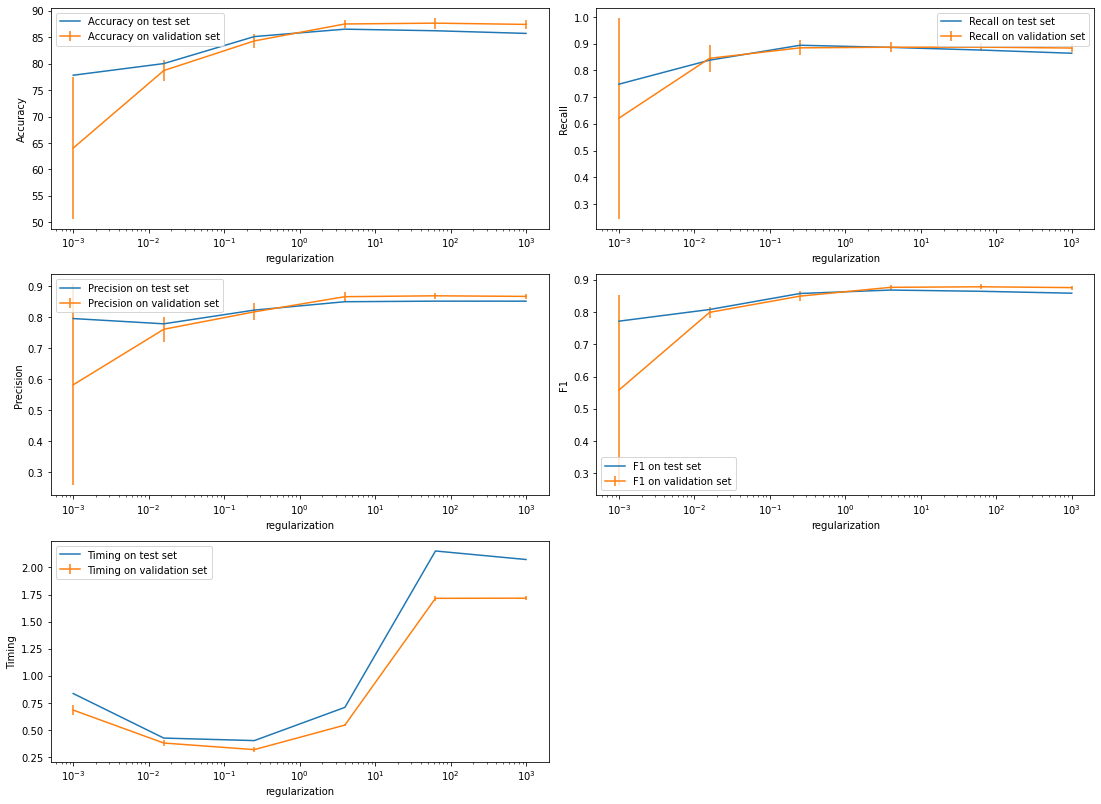


Highest average accuracy on validation set: 87.640 with regularization of 63.0957344480193

Accuracy on test set:  87.640 with regularization of 63.0957344480193

Accuracy:  86.200


In [31]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
metrics_lr_reviews = logistic_regression_reviews_tester.test()
metrics_lr_reviews.show_results(log=True)
m = metrics_lr_reviews.get_best()

### 2.2 Naive Bayes

In [32]:
movie_sets_naive = sets(X_train, Y_train, X_test, Y_test, test_prop = 0.2, rel_size = 0.2)

In [35]:
print(f'Training set size: {movie_sets_naive.y_train.shape}')
print(f'Test set size: {movie_sets_naive.y_test.shape}')

Training set size: (5000,)
Test set size: (1000,)


In [37]:
HYPERPARAMETERS = np.logspace(-8,2,10)
HYPERPARAMETER_NAME = 'alpha' 

naive_bayes_tester = model_tester(MultinomialNaiveBayes, movie_sets_naive, HYPERPARAMETERS,
                                  hyperparameter_name=HYPERPARAMETER_NAME)

In [38]:
metrics_reviews_naive = naive_bayes_tester.test()

...Training and testing for hyperparameter 1 on validation fold 1
...Training and testing for hyperparameter 1 on validation fold 2
...Training and testing for hyperparameter 1 on validation fold 3
...Training and testing for hyperparameter 1 on validation fold 4
...Training and testing for hyperparameter 1 on validation fold 5
...Training and testing for hyperparameter 1 on test set
...Training and testing for hyperparameter 2 on validation fold 1
...Training and testing for hyperparameter 2 on validation fold 2
...Training and testing for hyperparameter 2 on validation fold 3
...Training and testing for hyperparameter 2 on validation fold 4
...Training and testing for hyperparameter 2 on validation fold 5
...Training and testing for hyperparameter 2 on test set
...Training and testing for hyperparameter 3 on validation fold 1
...Training and testing for hyperparameter 3 on validation fold 2
...Training and testing for hyperparameter 3 on validation fold 3
...Training and testing for 

<Figure size 432x288 with 0 Axes>

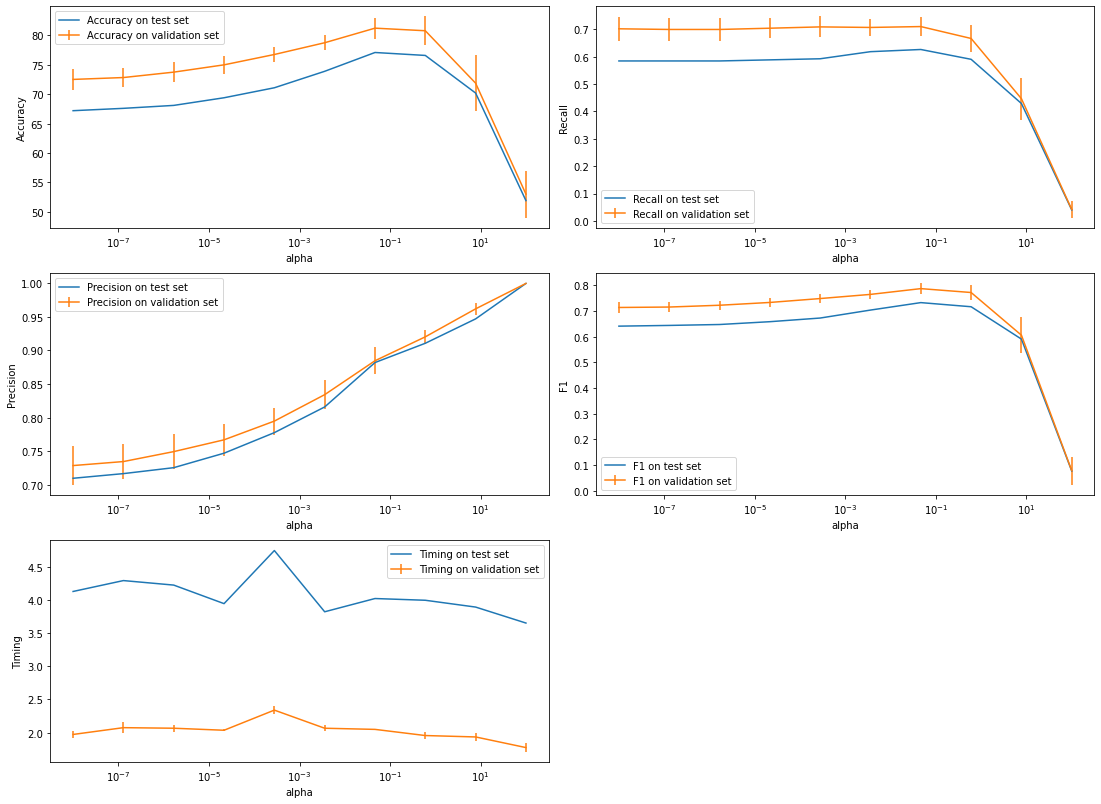


Highest average accuracy on validation set: 81.240 with alpha of 0.04641588833612782

Accuracy on test set:  81.240 with alpha of 0.04641588833612782

Accuracy:  77.100


In [39]:
metrics_reviews_naive.show_results(log=True)
m = metrics_reviews_naive.get_best()

##3 Twenty News group

In [58]:
twenty_train = fetch_20newsgroups(subset = 'train', remove = ['headers','footers','quotes'], shuffle=True)
twenty_test = fetch_20newsgroups(subset = 'test', remove = ['headers','footers','quotes'], shuffle=True)

X_train, Y_train = twenty_train.data, twenty_train.target
X_test, Y_test= twenty_test.data, twenty_test.target

VECTORIZER_TYPE = 'cv'
NGRAMS = (1,1)

X_train, X_test = preprocess(X_train, X_test, vectorizer_type = VECTORIZER_TYPE, ngrams = NGRAMS)

###3.1 Logistic Regression



In [59]:
twenty_sets_news_lr = sets(X_train, Y_train, X_test, Y_test, test_prop = 0.2, rel_size = 0.6)

In [60]:
print(f'Training set size: {twenty_sets_news_lr.y_train.shape}')
print(f'Test set size: {twenty_sets_news_lr.y_test.shape}')

Training set size: (6788,)
Test set size: (1000,)


In [61]:
HYPERPARAMETERS = np.logspace(-3,3,6)
HYPERPARAMETER_NAME = 'regularization' #'regularization' or 'max iteration'
SOLVER = 'lbfgs' #'saga' or 'lbfgs'

lr_news_tester = model_tester(logistic_regression, twenty_sets_news_lr, HYPERPARAMETERS,
                              hyperparameter_name = HYPERPARAMETER_NAME, solver = SOLVER)

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
news_metrics_lr = lr_news_tester.test()


<Figure size 432x288 with 0 Axes>

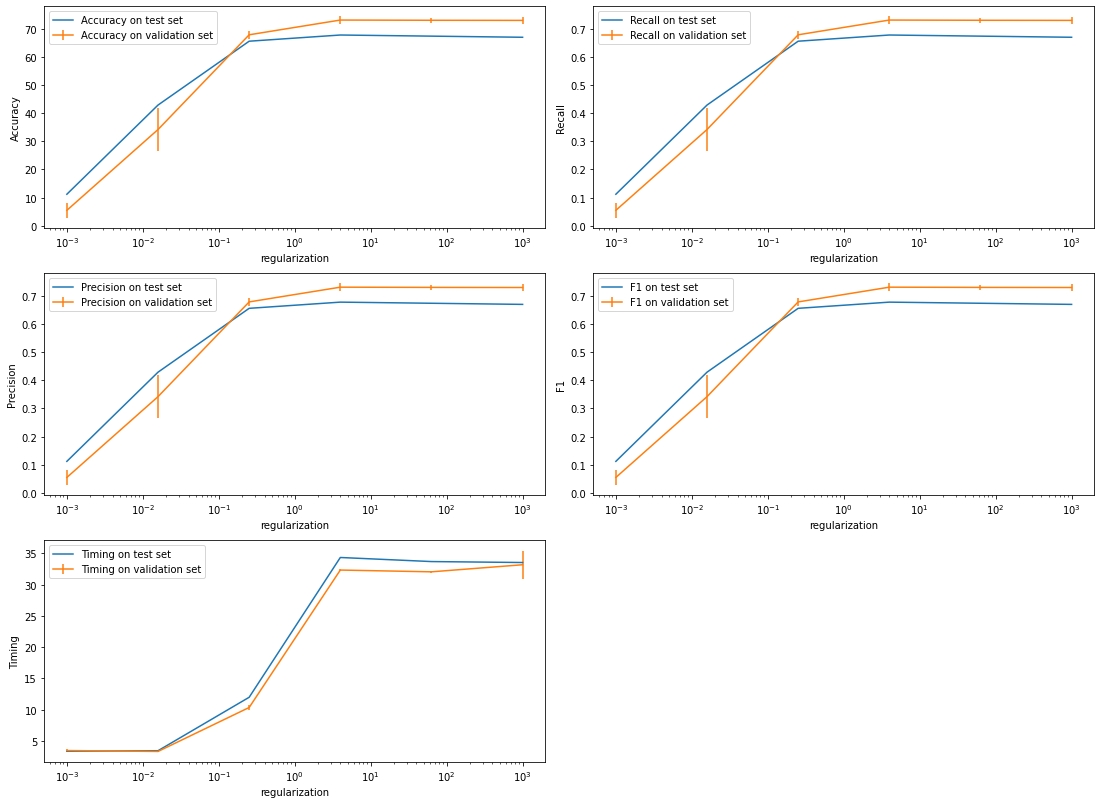


Highest average accuracy on validation set: 73.120 with regularization of 3.981071705534969

Accuracy on test set:  73.120 with regularization of 3.981071705534969

Accuracy:  67.800


In [63]:
news_metrics_lr.show_results(log = True)
m = news_metrics_lr.get_best()

### 3.2 Naive Bayes

In [64]:
twenty_sets_news_naive = sets(X_train, Y_train, X_test, Y_test, test_prop = 0.05, rel_size = 1.0)

In [67]:
print(f'Training set size: {twenty_sets_news_naive.y_train.shape}')
print(f'Test set size: {twenty_sets_news_naive.y_test.shape}')

Training set size: (11314,)
Test set size: (565,)


In [68]:
HYPERPARAMETERS = np.logspace(-6, -1, 7)
HYPERPARAMETER_NAME = 'alpha' 

naive_bayes_news_tester = model_tester(MultinomialNaiveBayes, twenty_sets_news_naive,
                                       HYPERPARAMETERS,hyperparameter_name=HYPERPARAMETER_NAME)

In [ ]:
news_metrics_naive = naive_bayes_news_tester.test()

...Training and testing for hyperparameter 1 on validation fold 1
...Training and testing for hyperparameter 1 on validation fold 2
...Training and testing for hyperparameter 1 on validation fold 3
...Training and testing for hyperparameter 1 on validation fold 4
...Training and testing for hyperparameter 1 on validation fold 5
...Training and testing for hyperparameter 1 on test set
...Training and testing for hyperparameter 2 on validation fold 1
...Training and testing for hyperparameter 2 on validation fold 2
...Training and testing for hyperparameter 2 on validation fold 3
...Training and testing for hyperparameter 2 on validation fold 4
...Training and testing for hyperparameter 2 on validation fold 5
...Training and testing for hyperparameter 2 on test set
...Training and testing for hyperparameter 3 on validation fold 1
...Training and testing for hyperparameter 3 on validation fold 2
...Training and testing for hyperparameter 3 on validation fold 3
...Training and testing for 

In [ ]:
news_metrics_naive.show_results()
m = news_metrics_naive.get_best()